# Dependencies

In [1]:
# import 
from svm_discriminator import *

# for other later use
import pandas as pd
import numpy as np
import os

# Load and use a generated model

Loading and using the generated model is very, very simple. 

### Loading
To load, we can use the `load_model(path_to_model)` function in the `svm_discriminator` library. You just need to provide the directory (`path_to_model`) with all the model files inside. This returns a `SVMSedimentDiscriminator`, which is assigned to the `classifier` variable below.

### Classification
To classify, you can use the `classifier.predict(samples)` method. `samples` is a (num_samples, 8) array which is read directly from the existing image processing output. This method returns a (num_samples, ) array, `prediction`. `prediction` is a logical array where `1` corresponds to sand and `0` corresponds to mud, and these are the model predictions.

### Reading data from file
Additionally, to read data immediately from the output of the image processing tools, use the `parse_output_from_file(file)` function, where `file` is a directory to a .csv or .xls(x) file. Note, that if you are predicting manually for whatever reason, and not using the `parse_output_from_file` function, you need to remove the first column of data (corresponding to "Number").

In [4]:
# ===== STEP 1: LOAD THE MODEL =====
# specify the path containing all three model output files
model_path = os.path.abspath(r"./generated_model")
classifier = load_model(model_path)

# ===== STEP 2: CLASSIFY USING THE MODEL =====
# build a sample to test that the model is working
test_sample = np.array([[5000, 800, 100, 120, 0.38, 2, 0.44, 1.1]])

# predict the output of the sample
# note: 1 = sand, 0 = mud
prediction = classifier.predict(test_sample) # prediction, confidence are arrays
print("predicted: {}".format("sand" if prediction[0] else "mud"))

predicted: mud


That should be everything!

# Train the Sediment Discriminator Model
If you're curious, this part adds some specification to how the model is trained and its architecture.

The first step is to initialize the data used for training.

In [7]:
# the path to the data
data_path = os.path.abspath(r"./data/Combined_TrainData_Reduced.xlsx")

# read the training data 
training_data_array = parse_output_from_file(data_path)

# separate the training data and the labels
training_data = training_data_array[:,:-1] # exclude the label 
training_labels = training_data_array[:,-1]

Initialize the model

In [8]:
classifier = SVMSedimentDiscriminator()

Plot the singular values of the training array to show how many dimensions should be in the latent space.

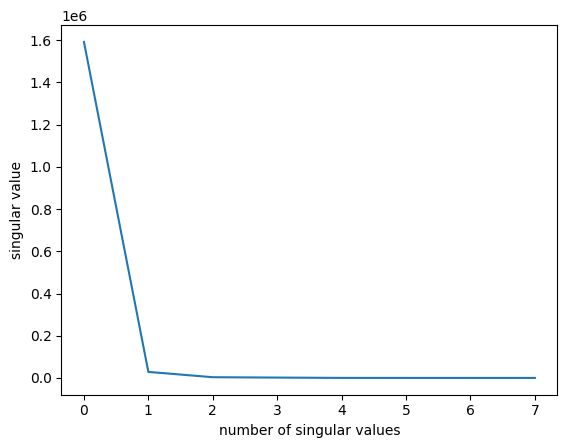

In [9]:
u, s, v = np.linalg.svd(training_data)

plt.plot(s)
plt.xlabel('number of singular values')
plt.ylabel('singular value')
plt.show()

In [14]:
print(u[0][0:8])

[-0.0087097   0.00677336  0.01647558 -0.0007071   0.01055987  0.00452344
  0.01752631 -0.00305358]


Train and validate the model on the training data

In [5]:
c_space = [34, 50]
gamma_space = [0.009, 0.09]
svm_fitting_params = {'C': c_space, 'gamma': gamma_space}

accuracy = classifier.train_model(training_data, 
                                  training_labels, 
                                  epochs=200, 
                                  debug=True, 
                                  svm_fitting_params=svm_fitting_params, 
                                  batch_size=1000)

print(f"model training complete with {100*accuracy:.2f}% accuracy on the training data")

fitting the support vector machine...
done
   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0       0.185945      0.034245         0.131460        0.025213      34   
1       0.229833      0.031316         0.124578        0.037571      34   
2       0.177584      0.035340         0.134012        0.026574      50   
3       0.230663      0.016083         0.103852        0.019723      50   

  param_gamma                     params  split0_test_score  \
0       0.009  {'C': 34, 'gamma': 0.009}           0.996046   
1        0.09   {'C': 34, 'gamma': 0.09}           0.996924   
2       0.009  {'C': 50, 'gamma': 0.009}           0.997364   
3        0.09   {'C': 50, 'gamma': 0.09}           0.996924   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.997364           0.996046           0.998242           0.996923   
1           0.997364           0.996485           0.997802           0.996484   
2           0.997364  

Print the model hyperparameters

In [6]:
print("C = {}, gamma = {}, kernel = {}".format(classifier.model.C, classifier.model.gamma, classifier.model.kernel))

C = 50, gamma = 0.009, kernel = rbf


Save the model

In [7]:
# initialize the save path for the model
model_path = os.path.abspath(r"./generated_model")

# save the model
classifier.save_model(model_path)